<a href="https://colab.research.google.com/github/Jectrianama/GCCE_TEST/blob/main/GCCE/tictactoe_onehot_gcce_randose_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow==2.7.0
#!pip install scikeras

# Subclassing for GCCE

In [ ]:
# -*- coding: utf-8 -*-
import tensorflow as tf
import matplotlib.pyplot as plt
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow_probability as tfp
from tensorflow.keras import regularizers
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split
tf.keras.backend.clear_session()
#tf.random.set_seed(42)
import types
import tempfile
class Keras_MA_GCCE(): #transformer no va
 #Constructor __init__. Special method: identified by a double underscore at either side of their name
 #work in the background
 # initialize data members to the object. lets the class initialize the object’s attributes and serves no other purpose.
    def __init__(self,epochs=100,batch_size=30,R=5, K=2, dropout=0.5, learning_rate=1e-3,optimizer='Adam', 
                  l1_param=0, validation_split=0.3, verbose=1, q = 0.1):
        self.epochs=epochs
        self.dropout=dropout
        self.batch_size = batch_size
        self.learning_rate=learning_rate 
        self.l1_param=l1_param 
        self.l2_param=l1_param
        self.validation_split = validation_split
        self.verbose = verbose
        self.optimizer = optimizer
        self.R=R
        self.K=K
        self.q = q

    
 
    def custom_RCDNN_loss(self, y_true, y_pred):  #ytrue \in N x R,  ypred \in N x (R+K) -> PRI->JULI
    
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 

        #Ground truth estimation samples (N) x  Classes(K)
        pred = y_pred[:,self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1-1e-9) #estabilidad numerica de la funcion de costo
        # Annotators reliability prediction: samples (N) x  annotators (R)
        ann_ = y_pred[:,:self.R]
        #Y_true 1-K: samples (N) x  Classes(1-K), annotators (R)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)
        #loss computation
        p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
        temp1 = ann_*tf.math.log(p_logreg)  
        temp2 = (1 - ann_)*tf.math.log(1/self.K)*tf.reduce_sum(Y_true,axis=1)
        # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
        # print(tf.reduce_mean(Y_true,axis=1).numpy())
        return -tf.math.reduce_sum((temp1 + temp2))

        
    def GCCE_MA_loss(self, y_true, y_pred):
        # print(y_true,y_pred)
       # q = 0.1
        pred = y_pred[:, self.R:]
        pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
        ann_ = y_pred[:, :self.R]
        # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
        Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
        Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

        p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
        temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)

        # p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
        # temp1 = ann_*tf.math.log(p_logreg)  
        # temp2 = (1 - ann_)*tf.math.log(1/K)*tf.reduce_sum(Y_true,axis=1)
        # aux = tf.repeat(tf.reduce_sum(pred*tf.math.log(pred),axis=1,keepdims=True), R, axis = 1)
        # tf.print(tf.shape(aux))
        # print(tf.shape(aux))
        # temp2 = (1 - ann_)*aux*tf.reduce_sum(Y_true,axis=1)
        # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
        # print(tf.reduce_mean(Y_true,axis=1).numpy())
        # Y_true_1 = tf.clip_by_value(Y_true, clip_value_min=1e-9, clip_value_max=1)
        # p_logreg_inv = tf.math.reduce_prod(tf.math.pow(Y_true_1, Y_hat), axis=1)
        # temp2 = (1 - ann_)*tf.math.log(p_logreg_inv) 
        temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
        return tf.math.reduce_sum((temp1 + temp2))

 
    def PRI_MA_loss(self, y_true, y_pred): #,  -> PRI
        #Input ytrue: samples (N) x  annotators (R) 
        #Input ypred: samples (N) x  annotators+classes (R+K) 
        #PRI MA
        cce_M = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=-1)
        cce_C = tf.keras.losses.CategoricalCrossentropy(reduction='none',axis=1)

      

        #N = tf.cast(y_true.shape[0],dtype=tf.int32)
        N = tf.shape(y_true)[0]
        #Ground truth estimation samples (N) x  Classes(K)
        y_pred_tf = y_pred[:,self.R:] 
        # Annotators reliability prediction: samples (N) x  annotators (R)
        lambda_R_tf = y_pred[:,:self.R] #tf.ones(shape=(N,R)) 
        #Y_true 1 K: samples (N) x  Classes(1-K), annotators (R)
        Y_true_1K = tf.one_hot(tf.cast(y_true,dtype=tf.int32),depth=self.K,axis=1)  
        #Y_pred 1 - K: samples (N) x  Classes(1-K), annotators (R)
        Y_hat = tf.repeat(tf.expand_dims(y_pred_tf,-1), self.R, axis = -1) 
        #marginal entropy
        #cce along the K classes -> ypred_tf
        Hm_ = cce_M(y_pred_tf,y_pred_tf)
        #cross entropy
        #cce along the K classes -> Y_hat
        Hc_ = cce_C(Y_true_1K,Y_hat)
        #PRI MA computation
        LH = tf.linalg.matmul(lambda_R_tf,Hc_,transpose_a=True) # \Lambda^\top H_c
        temp1 = tf.linalg.trace(LH) #trace(LH)
        Hm1L = tf.linalg.matmul(tf.ones(shape=(N,self.R))-lambda_R_tf,tf.ones(shape=(self.R,1)))# 1_N 1_R^\top - Lambda
        Hm_t = tf.reshape(Hm_,shape=(N,1))
        temp2 = tf.squeeze(tf.linalg.matmul(Hm_t,Hm1L,transpose_a=True)) # Hm^\top Hm1L
        loss_c = temp1+ temp2 #return loss

        return loss_c

 
    def fit(self, X, Y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        P = X.shape[1]
        if self.optimizer == "Adam":
            opt = tf.keras.optimizers.Adam(learning_rate=self.learning_rate, clipnorm=1.0)
        elif self.optimizer == "SGD":
            opt = tf.keras.optimizers.SGD(learning_rate=self.learning_rate, clipnorm=1.0)
        else:
            opt=self.optimizer

        #capa de entrada
        input_l = tf.keras.layers.Input(shape=(X_train.shape[1]), name='entrada')
        #capas densas
        h1 = tf.keras.layers.Dense(int(P*4*(self.K+self.R)),activation='selu',name='h1',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(input_l)#argumento de entrada
        h2 = tf.keras.layers.Dense(int(P*(self.K+self.R)),activation='selu',name='h2',
                              kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param))(h1)
        dout = tf.keras.layers.Dropout(rate=self.dropout)(h2)
        output_R = tf.keras.layers.Dense(self.R,activation="sigmoid", 
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param), name= 'out_R_GCCE' )(dout)
 
        output_K = tf.keras.layers.Dense(self.K,activation="softmax", 
                                    kernel_regularizer=tf.keras.regularizers.l1_l2(l1=self.l1_param,l2=self.l2_param), name= 'out_K_GCCE')(dout)
 
        output = tf.keras.layers.concatenate([output_R, output_K])
        self.model = tf.keras.Model(inputs= input_l,outputs=output)
        self.model.compile(loss=self.GCCE_MA_loss, optimizer=opt)
 
        self.history = self.model.fit(X, Y, epochs=self.epochs, validation_split=self.validation_split,   #
                                      batch_size=self.batch_size,verbose=self.verbose)
 
        return self
 
  
    
    def predict(self, X, *_):
       #input X numpy array first dimension samples (N)x features (P)
      return  self.model.predict(X) 
 
 

    def fit_predict(self,X,y):
        #input X numpy array first dimension samples (N)x features (P)
        #input Y numpy array vector len = samples (N) x  annotators (R)
        self.fit(X,y)
        return self.predict(X)
  
     #graphics
    def plot_history(self):
        pd.DataFrame(self.history.history).plot(figsize=(8, 5))
        plt.grid(True)
        #plt.gca().set_ylim(0, 1)
        #save_fig("keras_learning_curves_plot")
        plt.show()
        return
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)

        return self
    
    
    
    def get_params(self, deep=True):
        return { 'l1_param':self.l1_param, 'dropout':self.dropout, 'optimizer':self.optimizer,
                'learning_rate':self.learning_rate, 'batch_size':self.batch_size,
                'epochs':self.epochs, 'verbose':self.verbose, 'validation_split':self.validation_split,
                'R':self.R, 'K':self.K, 'q':self.q
                }

  
        return self


In [ ]:
#cargar datos desde drive otros dataset
FILEID = "1AU8pTtCLihBjCZjWITaAzpnEuL4RO436"
#https://drive.google.com/file/d/1AU8pTtCLihBjCZjWITaAzpnEuL4RO436/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O  DataGCCE.zip && rm -rf /tmp/cookies.txt
!unzip -o DataGCCE.zip
!dir

--2022-12-18 03:55:03--  https://docs.google.com/uc?export=download&confirm=&id=1AU8pTtCLihBjCZjWITaAzpnEuL4RO436
Resolving docs.google.com (docs.google.com)... 142.250.188.46, 2607:f8b0:4004:835::200e
Connecting to docs.google.com (docs.google.com)|142.250.188.46|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dfnrg4jusl7eh7rt060uoe8hvfdludm1/1671335700000/07591141114418430227/*/1AU8pTtCLihBjCZjWITaAzpnEuL4RO436?e=download&uuid=175e9757-4e88-4b74-95f2-1f4099769f93 [following]
--2022-12-18 03:55:03--  https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dfnrg4jusl7eh7rt060uoe8hvfdludm1/1671335700000/07591141114418430227/*/1AU8pTtCLihBjCZjWITaAzpnEuL4RO436?e=download&uuid=175e9757-4e88-4b74-95f2-1f4099769f93
Resolving doc-00-90-docs.googleusercontent.com (doc-00-90-docs.googleusercontent.com)... 172.253.63.132, 2607:f8b0:40

In [ ]:
#cargar datos desde drive acceso libre
FILEID = "1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW"
#https://drive.google.com/file/d/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW/view?usp=sharing
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O MADatasets.zip && rm -rf /tmp/cookies.txt
!unzip -o MADatasets.zip
!dir

--2022-12-18 03:55:04--  https://docs.google.com/uc?export=download&confirm=t&id=1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW
Resolving docs.google.com (docs.google.com)... 142.250.188.46, 2607:f8b0:4004:835::200e
Connecting to docs.google.com (docs.google.com)|142.250.188.46|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7jhl5m98jn32nl0q4jet4b7qcs4bfe5r/1671335700000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=c6f50288-8d4f-4e92-a81c-86e617045b32 [following]
--2022-12-18 03:55:04--  https://doc-00-90-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/7jhl5m98jn32nl0q4jet4b7qcs4bfe5r/1671335700000/07591141114418430227/*/1SQnWXGROG2Xexs5vn3twuv7SqiWG5njW?e=download&uuid=c6f50288-8d4f-4e92-a81c-86e617045b32
Resolving doc-00-90-docs.googleusercontent.com (doc-00-90-docs.googleusercontent.com)... 172.253.63.132, 2607:f8b0:4

# Load Data

In [ ]:
#load data
import scipy.io as sio
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf #importar tensorflow
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
database = 'TicTacToe'
data = pd.read_csv('/content/tic-tac-toe-endgame.csv')


In [ ]:
def onehot_encode(df, columns):
    df = df.copy()
    for column in columns:
        dummies = pd.get_dummies(df[column], prefix=column)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(column, axis=1)
    return df

def preprocess_inputs(df):
    df = df.copy()
    
    # Encode label values as numbers
    df['V10'] = df['V10'].replace({'negative': 0, 'positive': 1})
    
    # One-hot encode board space columns
    df = onehot_encode(
        df,
        columns=['V' + str(i) for i in range(1, 10)]
    )
    
    # Split df into X and y
    y = df['V10'].copy()
    X = df.drop('V10', axis=1).copy()
    
    # Train-test split
   # X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
    
    return X, y

In [ ]:
X, t = preprocess_inputs(data)

In [ ]:
X = np.array(X.values)
X

array([[0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 1]], dtype=uint8)

In [ ]:
t = np.array(t.values)
t

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
t =t+1
t

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
# if len(np.unique(t))== 2:
#     t=t+1

# Labels Generation - 1 Cluster, 3 annotators

In [ ]:
import random
import warnings
import numpy as np
#import climin
from functools import partial
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

#Defining the Sigmoid function and Softmax function
def Sigmoid(f_r):
    lam_r = 1/(1 + np.exp(-f_r))
    return lam_r

def MAjVot(Y, K):
    N,R = Y.shape
    Yhat = np.zeros((N,1))
    for n in range(N):
        votes = np.zeros((K,1))
        for r in range(R):
            for k in range(K):
                if Y[n,r] == k+1:
                    votes[k] = votes[k]+1
        Yhat[n] = np.argmax(votes) + 1
    return Yhat


def  MA_Clas_Gen(Xtrain,ytrain,R,NrP):

    N = len(ytrain)
    K = len(np.unique(ytrain))
    Kn = np.unique(ytrain)
    aux = 0
    A = np.zeros((K,1))
    for k in Kn:
        A[aux] = (ytrain == k).sum()
        aux = aux + 1
    per = np.min(A)
    if N < 25000:
        Xtrain = TSNE(n_components=1,perplexity=per/2).fit_transform(Xtrain)
    else:
        Xtrain = np.sum(Xtrain,1)
    # Xtrain = Xtrain-Xtrain.min()
    # Xtrain = Xtrain/Xtrain.max()
    #ytrain = y
    # scaler = StandardScaler()
    # scalerY = scaler.fit(y)
    # ytrain = scaler.fit_transform(y)

    
    #miny = y.min()
    #ytrain = y-miny
    #maxy = ytrain.max()
    #ytrain = ytrain/maxy
  
    # Xtrain = np.sum(Xtrain, axis=1)
    Xtrain = Xtrain - Xtrain.min()
    #print(Xtrain.min(), Xtrain.max())
    Xtrain = Xtrain/Xtrain.max()
    Xtrain = Xtrain.reshape((N,1))
    yprueba = np.ones((N,1))
    
    
    u_q = np.empty((Xtrain.shape[0],3))
    u_q[:,0,None] = 4.5*np.cos(2*np.pi*Xtrain + 1.5*np.pi) - \
                               3*np.sin(4.3*np.pi*Xtrain + 0.3*np.pi)
                    
    u_q[:,1,None] = 4.5*np.cos(1.5*np.pi*Xtrain + 0.5*np.pi) + \
                       5*np.sin(3*np.pi*Xtrain + 1.5*np.pi)
    
    u_q[:,2,None] = 1
    
    W = []
    # q=1
    Wq1 = np.array(([[0.4],[0.7],[-0.5],[0],[-0.7]]))
    W.append(Wq1)
    # q=2
    Wq2 = np.array(([[0.4],[-1.0],[-0.1],[-0.8],[1.0]]))
    W.append(Wq2)
    Wq3 = np.array(([[3.1],[-1.8],[-0.6],[-1.2],[1.0]]))
    W.append(Wq3)

    
    F_r = []
    Lam_r = []
    for r in range(R):
        f_r = np.zeros((Xtrain.shape[0], 1))
        # rho_r = np.zeros((Xtrain.shape[0], 1))
        for q in range(3):
            f_r += W[q][r].T*u_q[:,q,None]
        F_r.append(f_r)
        lam_r = Sigmoid(f_r)
        lam_r[lam_r>0.5] = 1
        lam_r[lam_r<=0.5] = 0
        Lam_r.append(lam_r)
    plt.plot(Xtrain,Lam_r[2],'rx')
    plt.show()
    seed = 0
    np.random.seed(seed)
    Ytrain = np.ones((N, R))
    for r in range(R):
        aux = ytrain.copy()
        for n in range(N):
            if Lam_r[r][n] == 0:
                labels = np.arange(1, K+1)
                a = np.where(labels==ytrain[n])
                labels = np.delete(labels, a)
                idxlabels = np.random.permutation(K-1)
                aux[n] = labels[idxlabels[0]]         
        Ytrain[:,r] = aux.flatten()
        
   # Ytrain = (Ytrain*maxy) + miny
        
    iAnn = np.zeros((N, R), dtype=int) # this indicates if the annotator r labels the nth sample.
    Nr = np.ones((R), dtype=int)*int(np.floor(N*NrP))  
    for r in range(R):
        if r < R-1:
            indexR = np.random.permutation(range(N))[:Nr[r]]
            iAnn[indexR,r] = 1
        else:
            iSimm = np.sum(iAnn, axis=1)
            idxZero = np.asarray([i for (i, val) in enumerate(iSimm) if val == 0])
            Nzeros = idxZero.shape[0]
            idx2Choose = np.arange(N)
            if Nzeros == 0:
                indexR = np.random.permutation(range(N))[:Nr[r]]
                iAnn[indexR,r] = 1
            else:
                idx2Choose = np.delete(idx2Choose, idxZero)
                N2chose = idx2Choose.shape[0]
                idxNoZero = np.random.permutation(N2chose)[:(Nr[r] - Nzeros)]
                idxTot = np.concatenate((idxZero, idx2Choose[idxNoZero]))
                iAnn[idxTot,r] = 1
    
    # Now, we verify that all the samples were labeled at least once
    Nr = (np.sum(iAnn,0))
    iSimm = np.sum(iAnn, axis=1)
    if np.asarray([i for (i, val) in enumerate(iSimm) if val == 0]).sum() == 0:
        ValueError("all the samples must be labeled at least once")

    # Finally, if iAnn=0 we assign a reference value to indicate a missing value
    Vref = -1e-20
    for r in range(R):
        Ytrain[iAnn[:,r] == 0, r] = Vref 

    return Ytrain, iAnn, Lam_r


def CrossVal(X, pp, Nk):
    N = X.shape[0]
    Ntr = int(N*pp)
    Nte = N - Ntr
    idxtr = np.zeros((Ntr,Nk))
    idxte = np.zeros((Nte,Nk))
    
    for i in range(Nk):
        index = np.random.permutation(range(N))
        idxtr[:,i] = index[:Ntr]
        idxte[:,i] = index[Ntr:]
        
    return idxtr, idxte
    
    
        


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


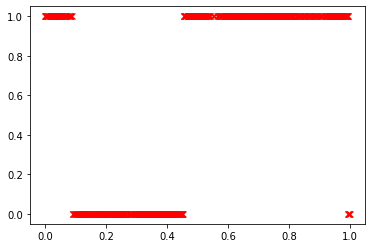

In [ ]:
Y, iAnn, Lam_r = MA_Clas_Gen(X ,t, R=5, NrP=1)

In [ ]:

  Y = Y - 1
  t = t - 1
  #YMA = YMA-1
  

annotator 1
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       332
           1       0.91      0.93      0.92       626

    accuracy                           0.90       958
   macro avg       0.89      0.88      0.89       958
weighted avg       0.90      0.90      0.90       958

annotator 2
              precision    recall  f1-score   support

           0       0.43      0.68      0.53       332
           1       0.76      0.52      0.62       626

    accuracy                           0.58       958
   macro avg       0.59      0.60      0.57       958
weighted avg       0.64      0.58      0.59       958

annotator 3
              precision    recall  f1-score   support

           0       0.45      0.52      0.48       332
           1       0.72      0.66      0.69       626

    accuracy                           0.61       958
   macro avg       0.59      0.59      0.59       958
weighted avg       0.63      0.61     

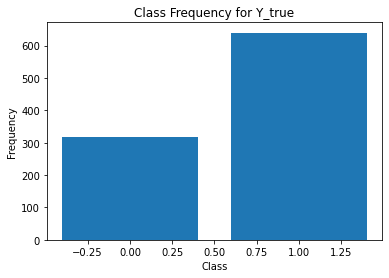

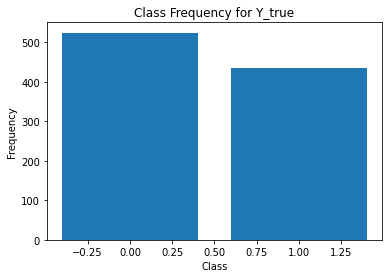

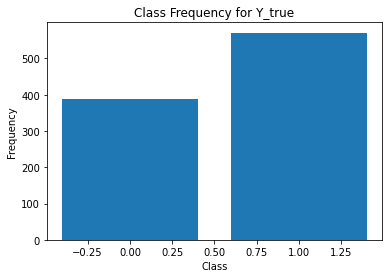

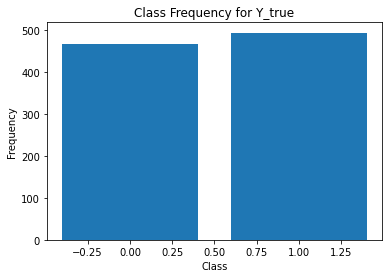

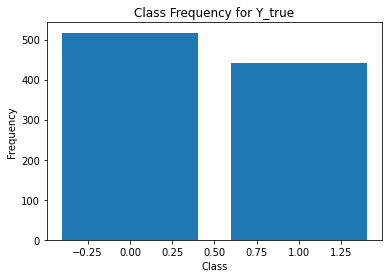

In [ ]:
from sklearn.metrics import classification_report
for i in range(Y.shape[1]):
    print('annotator',i+1)
    print(classification_report(t,Y[:,i]))
    unique, counts = np.unique(Y[:,i], return_counts=True)
    plt.figure()
    plt.bar(unique, counts)
#     unique, counts = np.unique(Y_test[5], return_counts=True)
#     plt.bar(unique, counts)

    plt.title('Class Frequency for Y_true')
    plt.xlabel('Class')
    plt.ylabel('Frequency')


In [ ]:
# from sklearn.metrics import classification_report
# for i in range(Y.shape[1]):
#   for j in range(len(np.unique(clusters.labels_))):
#     print('annotator',i+1)
#     print('cluster',j+1)
#     print(classification_report(t[clusters.labels_==j],Y[clusters.labels_==j,i]))

# Split data

In [ ]:
import numpy.matlib
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
Ns = 1
ss = ShuffleSplit(n_splits=Ns, test_size=0.3,random_state =123)
for train_index, test_index in ss.split(X):
    print(test_index)
    X_train, X_test,Y_train,Y_test = X[train_index,:], X[test_index,:],Y[train_index,:], Y[test_index,:]
    Y_true_train, Y_true_test = t[train_index].reshape(-1,1), t[test_index].reshape(-1,1)
print(X_train.shape, Y_train.shape, Y_true_train.shape)

[246 188 392 518 854 291 802 164 674 861 863 606 138   7 203 525 204 770
 343 185 591 663 774 914 270 455 900 161 261 353 396 260 210 524 752 147
 605 907 925 363 453 316 735 566 883 818 568 318 684  85 267 370 252 773
 789 683 376 660 715 565 878   5 677 571 167  41 184 200 272 814 732 893
 731 719 458 689  48 795 131 701 172 775 195 955  35 832 613 134 885 426
   4 753 478 415 381 650 399 430  50 888 882 617 328 560 280 227 274 388
 546 598  57 687 926 338 417  52 279 913 303  55 384  28 336 314 145 758
 103 114 500 706 345 811 512  54 117 619 171 462 348 221  31 444 610  36
 804 727 421 643 844 327 100 884 897 162 644 275 483 809 892 738 760  78
 463 659 306  79 177 369 310 904 351 346 229  91 170 920  90  75 372 929
 299 855 521 874 273 859 239 898 694 236 678 209 335 196 648 776  13  74
 889 249 461  59 690 456 437 151 567  11 858 769 856 285 692 733  95 797
 623 833 754 798 726 877 793 269 368 903 387 739 266 551 235 317 729 182
 374 666 107 482  97 767 538  43 908 944 781 226 15

In [ ]:
# for i in range(Y.shape[1]):
#     print('annotator',i+1)
   
#     unique, counts = np.unique(Y_train[:,i], return_counts=True)
#     plt.figure()
#     plt.bar(unique, counts)
#     unique, counts = np.unique(Y_test[:,i], return_counts=True)
#     plt.bar(unique, counts)

#     plt.title('Class Frequency for Y_true')
#     plt.xlabel('Class')
#     plt.ylabel('Frequency')


# Apply MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Testing the Class 


iteration: 0


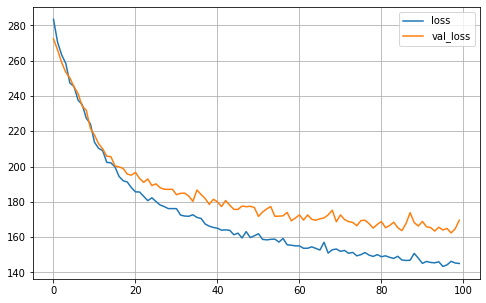

9/9 [==============================] - 0s 2ms/step
Validation aUc: 0.9817
iteration: 1


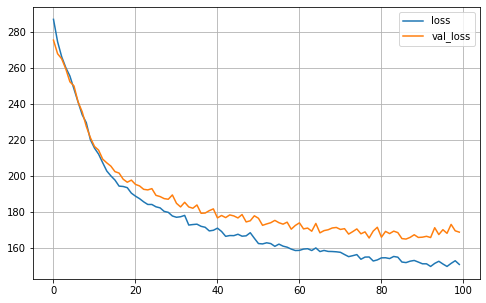

9/9 [==============================] - 0s 1ms/step
Validation aUc: 0.9771
iteration: 2


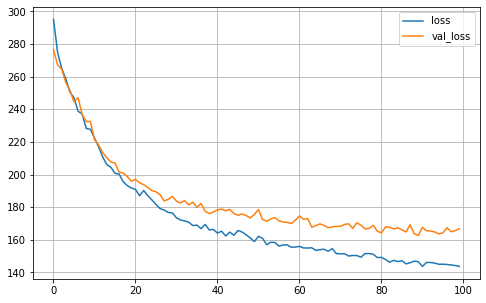

9/9 [==============================] - 0s 2ms/step
Validation aUc: 0.9817
iteration: 3


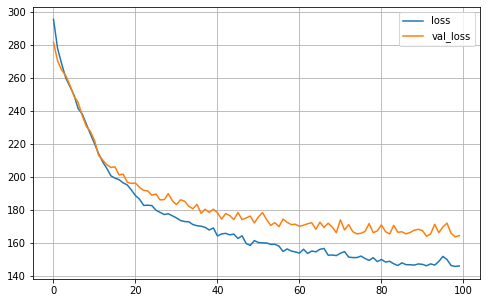

9/9 [==============================] - 0s 2ms/step
Validation aUc: 0.9817
iteration: 4


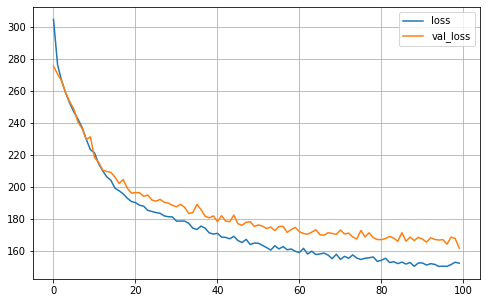

9/9 [==============================] - 0s 2ms/step
Validation aUc: 0.9807
iteration: 5


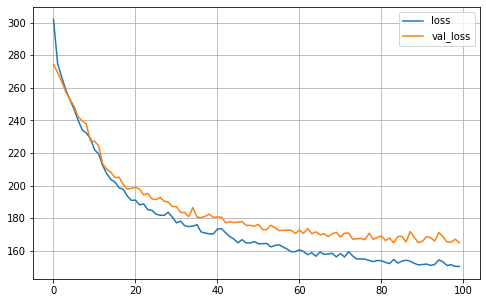

9/9 [==============================] - 0s 2ms/step
Validation aUc: 0.9817
iteration: 6


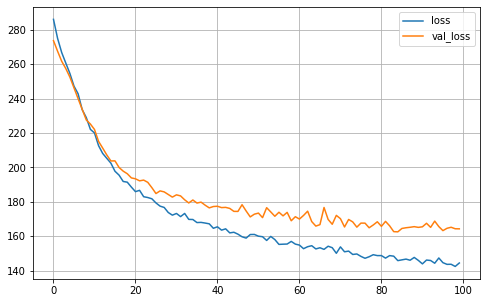

9/9 [==============================] - 0s 2ms/step
Validation aUc: 0.9817
iteration: 7


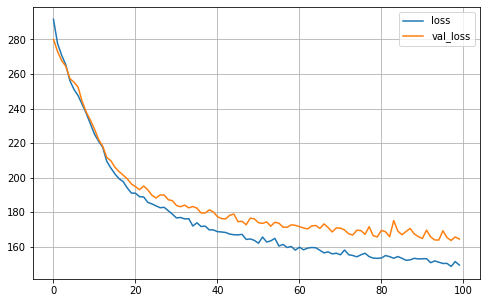

9/9 [==============================] - 0s 2ms/step
Validation aUc: 0.9789
iteration: 8


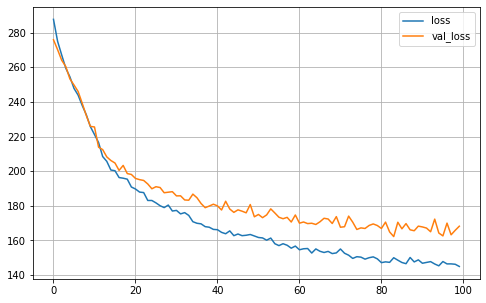

9/9 [==============================] - 0s 2ms/step
Validation aUc: 0.9817
iteration: 9


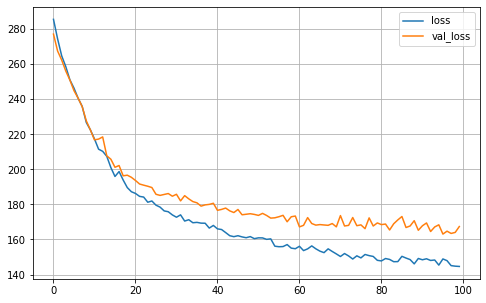

9/9 [==============================] - 0s 3ms/step
Validation aUc: 0.9807


In [ ]:
from sklearn.metrics import classification_report

l1 =0.01
NUM_RUNS =10
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
for i in range(NUM_RUNS): #10
    print("iteration: " + str(i))
   
    MA = Keras_MA_GCCE(epochs=100,batch_size=64,R=5, K=len(np.unique(Y_true_train)), dropout=0.5, learning_rate=0.001,optimizer='Adam', 
                l1_param=l1,  validation_split=0.30, verbose=0, q=0.1)

    MA.fit(X_train, Y_train)
    MA.plot_history()
  
    #Accuracy
    pred_2 = MA.predict(X_test)
 
    report = classification_report( pred_2[:,Y.shape[1]:].argmax(axis=1),Y_true_test.ravel(),output_dict=True)
    ACC[i] = report['accuracy']
    #AUC
    val_AUC_metric = tf.keras.metrics.AUC(num_thresholds=3, from_logits = True)  
    val_logits =MA.predict(X_test) # model(X_test, training=False)
    # tf.print(y_batch_val)
    val_AUC_metric.update_state(Y_true_test, val_logits[:,Y.shape[1]:].argmax(axis=1).astype('float'))

    val_AUC = val_AUC_metric.result()
    val_AUC_metric.reset_states()
    val_AUC = val_AUC.numpy()
    print("Validation aUc: %.4f" % (float(val_AUC),))
    AUC[i] = val_AUC
    
  

In [ ]:

ACC

array([0.98611111, 0.98263889, 0.98611111, 0.98611111, 0.98263889,
       0.98611111, 0.98611111, 0.98263889, 0.98611111, 0.98263889])

In [ ]:

AUC

array([0.98165137, 0.97706425, 0.98165137, 0.98165137, 0.98065192,
       0.98165137, 0.98165137, 0.97885805, 0.98165137, 0.98065192])

In [ ]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)

Average Accuracy:  98.47
Average std:  0.16999999999999998


In [ ]:
print('Average Accuracy: ', np.round( AUC.mean(),4)*100) 
print('Average std: ',np.round(np.std( AUC),4)*100)

Average Accuracy:  98.07000000000001
Average std:  0.15
